# A walk through the scPortrait Ecosystem

This notebook will introduce you to the scPortrait ecosystem and give you a complete working example of how to use scPortrait. It will walk you through the following steps of the scPortrait workflow:
1. **segmentation**: Generates masks for the segmentation of input images into individual cells
2. **extraction**: The segmentation masks are applied to extract single-cell images for all cells in the input images. Images of individual cells are rescaled to [0, 1] per channel.
3. **classification**: The image-based phenotype of each individual cell in the extracted single-cell dataset is classified using the specified classification method. Multiple classification runs can be performed on the same dataset using different classification methods. Here we utilize the pretrained binary classifier from the original [SPARCS manuscript](https://doi.org/10.1101/2023.06.01.542416) that identifies individual cells defective in a biological process called "autophagy". 
4. **selection**: Cutting instructions for the isolation of selected individual cells by laser microdissection are generated. The cutting shapes are written to an ``.xml`` file which can be loaded on a leica LMD microscope for automated cell excision.

The data used in this notebook was previously stitched using the stitching workflow in [SPARCStools](https://github.com/MannLabs/SPARCStools). Please see the notebook [here](https://mannlabs.github.io/SPARCStools/html/pages/notebooks/example_stitching_notebook.html).

## Import Required Libraries

First we need to import all of the python functions we require to run the pipeline.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

from scportrait.pipeline.project import Project
from scportrait.pipeline.workflows import WGASegmentation
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.classification import MLClusterClassifier
from scportrait.pipeline.selection import LMDSelection

## Generate the Project Structure

Executing this code will generate a new scPortrait project in the designated location. Each scPortrait project has the following general structure:

                .
                ├── classification
                │   └── classifier_name
                │       └── processing.log
                ├── config.yml
                ├── extraction
                ├── segmentation
                └── processing.log

In [2]:
project_location = f"../../../example_data/example_1/project"

project = Project(os.path.abspath(project_location),
                  config_path= "../../../example_data/example_1/config_example1.yml",
                  overwrite=True,
                  debug=True,
                  segmentation_f=WGASegmentation,
                  extraction_f=HDF5CellExtraction,
                  classification_f=MLClusterClassifier,
                  selection_f=LMDSelection
                  )

Updating project config file.
[30/07/2024 23:41:03] Loading config from /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/config.yml
[30/07/2024 23:41:03] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/SPARCSspatial/docs_source/pages/notebooks.


/Users/sophia/Documents/GitHub/SPARCSspatial/src/scportrait/pipeline/project.py:108: UserWarning: There is already a directory in the location path
  warnings.warn("There is already a directory in the location path")


## Load Imaging Data

Once we have generated our project structure we next need to load our imaging data. There are several different ways to do this. 

1. you can load the images directly from file by specifying a list of filepaths
2. you can load the images from numpy arrays that are already loaded into memory

Here it is important that you load the channels in the following order: Nucleus, Cellmembrane, others

In this particular example we are utilizing images from U2OS cells which are stained with Hoechst 33342 to visualize nuclei and express Lck-mNeon to visualize the cellular membrane and LC3B-mcherry, a fluroescently tagged protein relevant for visualizing the biological process of autophagy. The cells have not been stimulated to induce autophagy and should be autophagy defective.

### Method 1: loading images from file

In [3]:
images = ["../../../example_data/example_1/input_images/Ch1.tif",
          "../../../example_data/example_1/input_images/Ch2.tif",
          "../../../example_data/example_1/input_images/Ch3.tif"]

project.load_input_from_tif_files(images)

[30/07/2024 23:03:41] Output location /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/sparcs.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/sparcs.sdata                  
[30/07/2024 23:03:41] Initialized temporary directory at /Users/sophia/Documents/GitHub/SPARCSspatial/docs_source/pages/notebooks/SpatialProject_ljonfq41 for SpatialProject
[30/07/2024 23:03:42] Image input_image written to sdata object.
[30/07/2024 23:03:42] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/SPARCSspatial/docs_source/pages/notebooks/SpatialProject_ljonfq41'>


### Method 2: loading images from numpy array

To simulate the case where the images you want to load are already loaded as a numpy array, we first convert the images to a numpy array and then pass this array to the project instead of only providing the image paths.

In [4]:
from tifffile import imread

images = ["../../../example_data/example_1/input_images/Ch1.tif",
          "../../../example_data/example_1/input_images/Ch2.tif",
          "../../../example_data/example_1/input_images/Ch3.tif"]

image_arrays = np.array([imread(path) for path in images])

project.load_input_from_array(image_arrays)

[30/07/2024 23:03:44] Output location /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/sparcs.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/sparcs.sdata                  
[30/07/2024 23:03:44] Image input_image written to sdata object.


### Looking at the loaded images

The loaded images are accesible via the input_image parameter of the project. They are saved into the underlying spatialdata object.

In [5]:
project.input_image

<xarray.DataArray 'image' (c: 3, y: 3040, x: 3038)> Size: 55MB
dask.array<array, shape=(3, 3040, 3038), dtype=uint16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U9 108B 'channel_0' 'channel_1' 'channel_2'
  * y        (y) float64 24kB 0.5 1.5 2.5 3.5 ... 3.038e+03 3.038e+03 3.04e+03
  * x        (x) float64 24kB 0.5 1.5 2.5 3.5 ... 3.036e+03 3.036e+03 3.038e+03
Attributes:
    transform:  {'global': Identity }

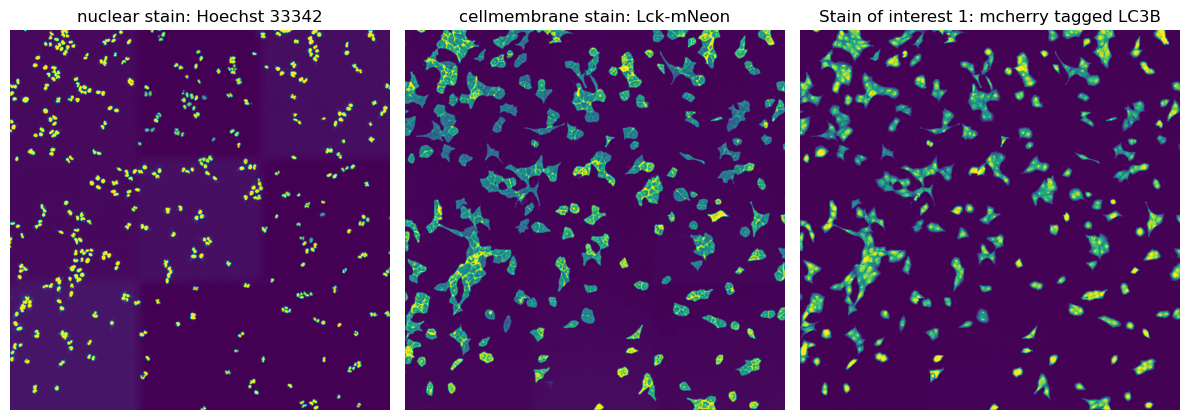

In [6]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

fig, axs = plt.subplots(1, 3, figsize = (12, 6));
axs[0].imshow(project.input_image[0]);
axs[0].axis("off");
axs[0].set_title("nuclear stain: Hoechst 33342")

axs[1].imshow(project.input_image[1]);
axs[1].axis("off");
axs[1].set_title("cellmembrane stain: Lck-mNeon")

axs[2].imshow(project.input_image[2]);
axs[2].axis("off");
axs[2].set_title("Stain of interest 1: mcherry tagged LC3B")

fig.tight_layout()

In [7]:
#alternatively you can also visualize the input images as well as all other objects saved in spatialdata object

project.view_sdata()

/Users/sophia/Documents/GitHub/napari-spatialdata/src/napari_spatialdata/_view.py:211: FutureWarning: Private attribute access ('Window._dock_widgets') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  self._model = model if model else napari_viewer.window._dock_widgets["SpatialData"].widget().viewer_model._model


## Generating a Segmentation

scPortrait has different segmentation workflows between which you can choose. If none of them fit your needs you can also easily write your own. 

Here we will demonstrate the CPU based classical segmentation method that was also utilized in the manuscript. 

We define the segmentation method to be used when we initialize the project. In this case we used the `WGASegmentation` method. The `ShardedWGASegmentation` works very similarily but allows you to process several image chunks in parallel for more efficient computation on large input images.

By specifying `debug = True` we can see intermediate output results from the segmentation. 

The `WGASegmentation` method relies on parameters specified in the `config.yml` we loaded when initializing our project.

        WGASegmentation:
        input_channels: 3
        cache: "."
        chunk_size: 50 # chunk size for chunked HDF5 storage
        lower_quantile_normalization:   0.001
        upper_quantile_normalization:   0.999
        median_filter_size:   4 # Size in pixels
        nucleus_segmentation:
            lower_quantile_normalization:   0.01 # quantile normalization of dapi channel before local tresholding Strong normalization (0.05,0.95) can help with nuclear speckles.
            upper_quantile_normalization:   0.99 # quantile normalization of dapi channel before local tresholding.Strong normalization (0.05,0.95) can help with nuclear speckles.
            median_block: 41 # Size of pixel disk used for median, should be uneven
            median_step: 4
            threshold: 0.2 # threshold above local median for nuclear segmentation
            min_distance: 8 # minimum distance between two nucleis in pixel
            peak_footprint: 7 # 
            speckle_kernel: 9 # Erosion followed by Dilation to remove speckels, size in pixels, should be uneven
            dilation: 0 # final dilation of pixel mask       
            min_size: 200 # minimum nucleus area in pixel
            max_size: 1000 # maximum nucleus area in pixel
            contact_filter: 0.5 # minimum nucleus contact with background
        cytosol_segmentation:
            threshold: 0.05 # treshold above which cytosol is detected
            lower_quantile_normalization: 0.01
            upper_quantile_normalization: 0.99
            erosion: 2 # erosion and dilation are used for speckle removal and shrinking / dilation
            dilation: 7 # for no change in size choose erosion = dilation, for larger cells increase the mask erosion
            min_clip: 0
            max_clip: 0.2
            min_size: 200
            max_size: 6000
        chunk_size: 50
        filter_masks_size: True

By passing the parameter ``debug = True`` we tell scPortrait to also generate intermediate outputs which we can look at to see the different segmentation steps. It is only recommended to do this for debugging or visualization purposes as it will utilize more memory and be slower.

For the ``WGASegmentation`` method the intermediate outputs that are displayed are the following: 

1. percentile normalized input images for each of the three channels (3 images)
2. median normalized input images (this slightl smooths the images for a better segmentation result) (3 images)
3. histogram showing the intensity distribution for nuclear and cytosolic channel (2 plots)
4. generated mask after applying nuclear thresholding
5. nuclear thresholding mask with calculated centers for each detected nucleus
6. fast marching map with nuclei centers indicated in red
7. segmented individual nuclei (2 different visualizations)
8. starting nucleus mask for filtering
9. histrogram showing size distribution of segmented nuclei
10. segmentation mask with too small nuclei shown in red
11. segmentation mask with too large nuclei shown in red
12. WGA thresholding mask
13. WGA potential map
14. WGA fast marching results
15. Watershed results with nuclear centers shown in red
15. WGA mask
16. Cytosol size distribution
10. cytosol mask with too small cells shown in red
11. cytosol mask with too large cells shown in red


/Users/sophia/Documents/GitHub/spatialdata/src/spatialdata/_core/spatialdata.py:157: UserWarning: The table is annotating 'seg_all_cytosol', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/sophia/Documents/GitHub/spatialdata/src/spatialdata/_core/spatialdata.py:157: UserWarning: The table is annotating 'seg_all_nucleus', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


[30/07/2024 23:36:11] Current Project Status:
[30/07/2024 23:36:11] --------------------------------
[30/07/2024 23:36:11] Input Image Status: True
[30/07/2024 23:36:11] Nucleus Segmentation Status: False
[30/07/2024 23:36:11] Cytosol Segmentation Status: False
[30/07/2024 23:36:11] Centers Status: True
[30/07/2024 23:36:11] --------------------------------
[30/07/2024 23:36:11] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./WGASegmentation_q2k8e7yz for WGASegmentation
[30/07/2024 23:36:11] Normalization of the input image will be performed.
[30/07/2024 23:36:11] Normalizing each channel to the same range
[30/07/2024 23:36:12] Performing median filtering on input image
[30/07/2024 23:36:25] Percentile normalization of nucleus input image to range 0.01, 0.99
[30/07/2024 23:36:25] Normalizing each channel to the same range
[30/07/2024 23:36:25] Using local thresholding with a threshold of 0.2 to calculate nucleus mask.


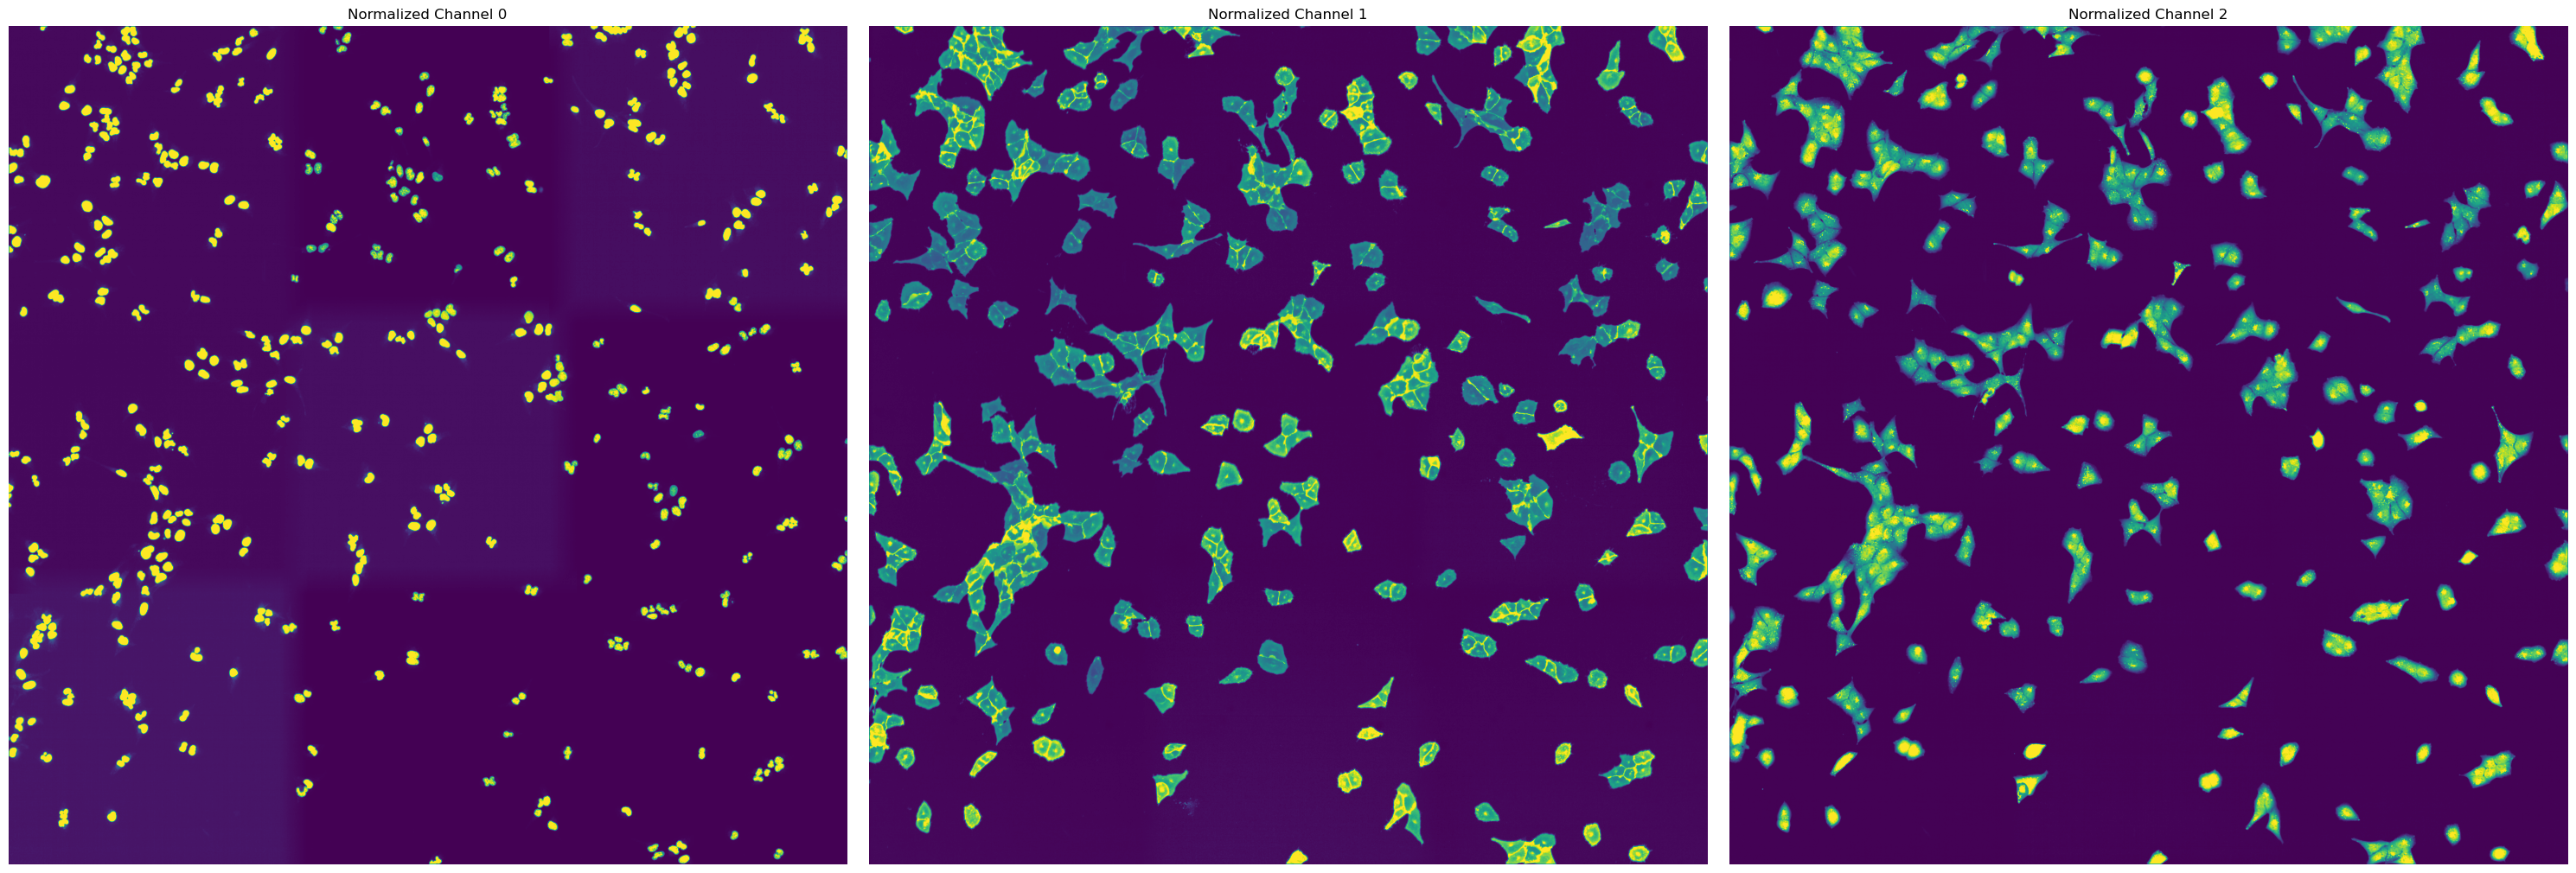

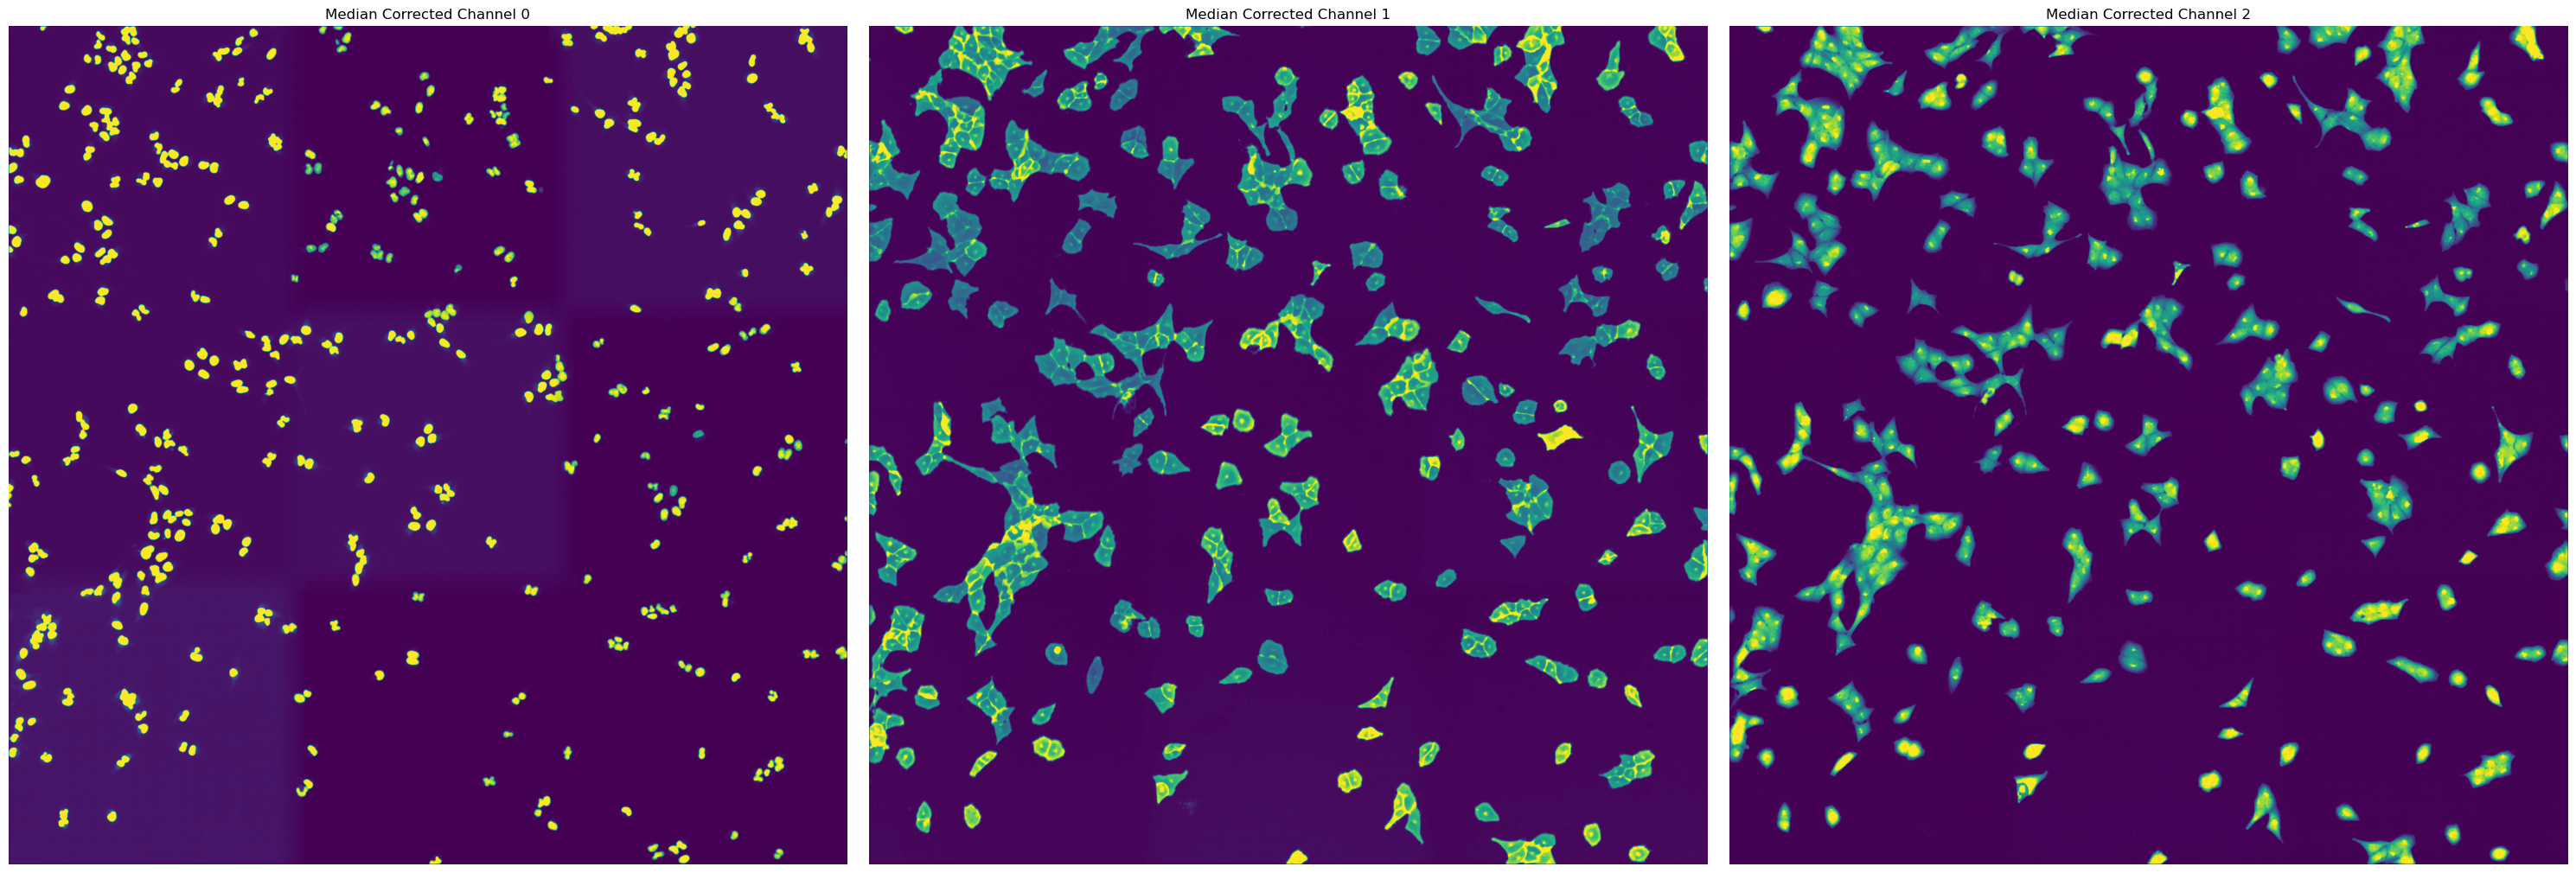

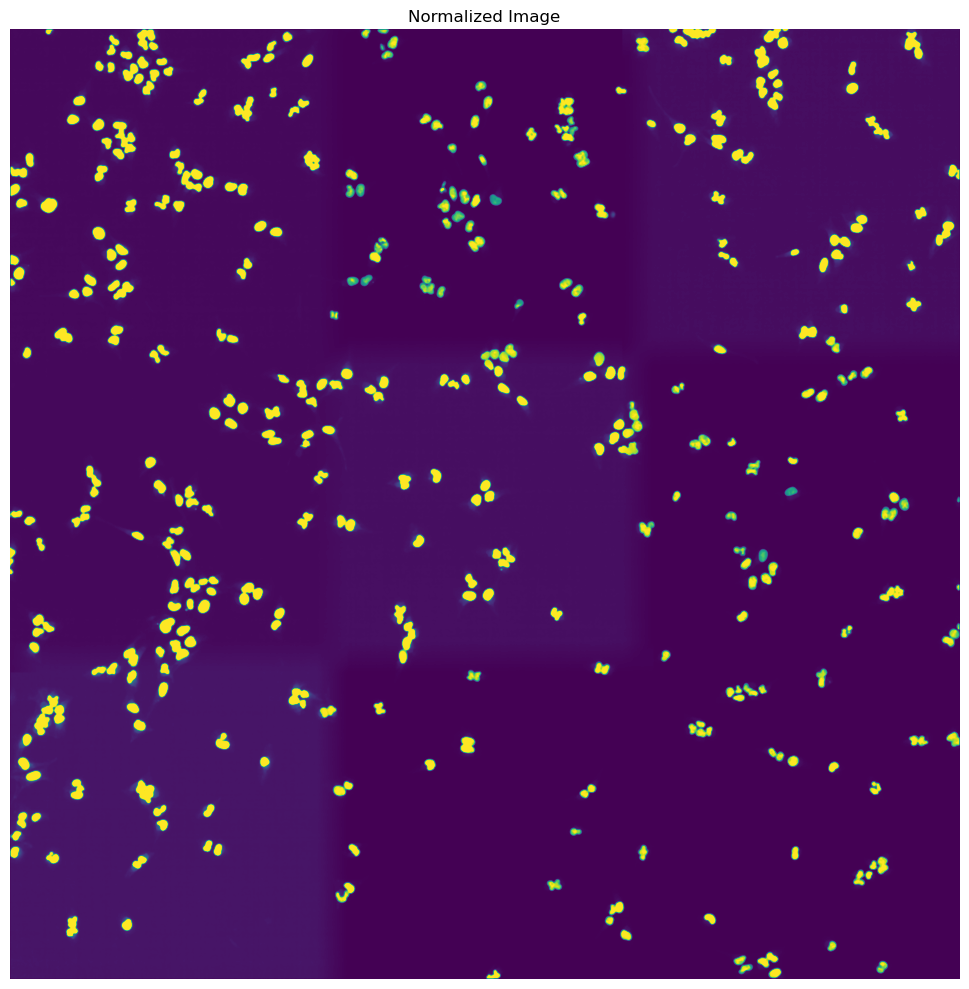

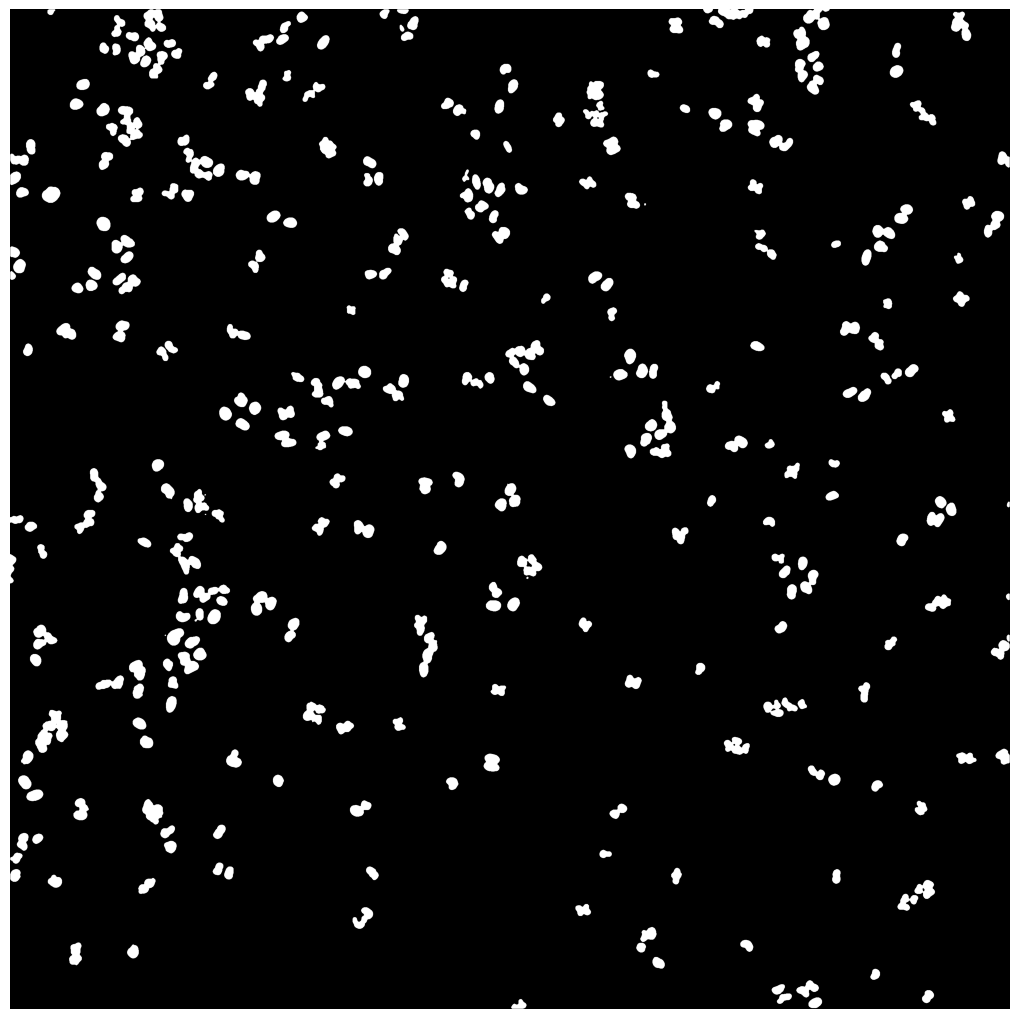

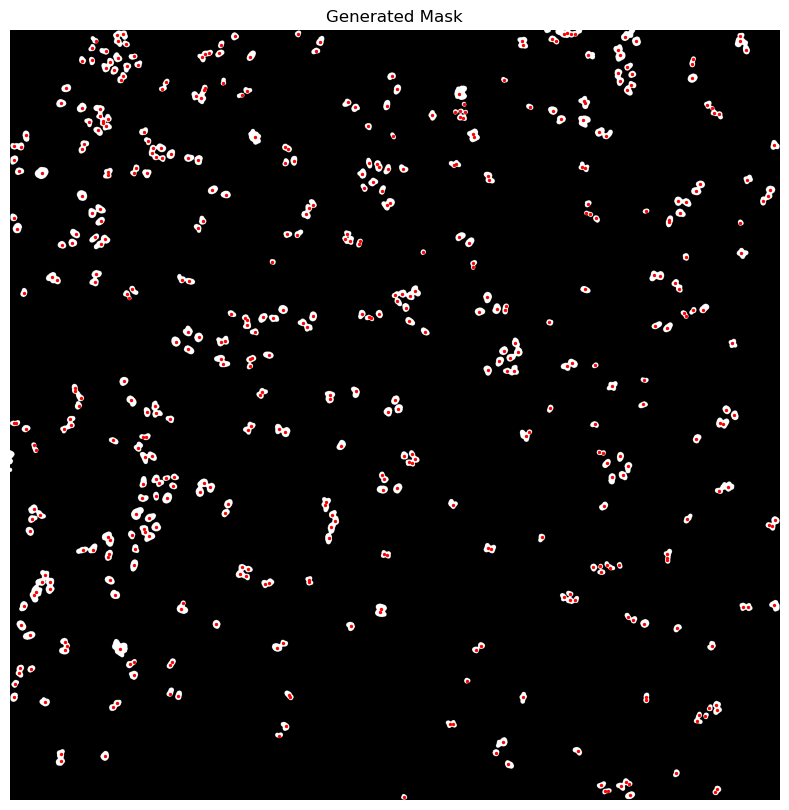

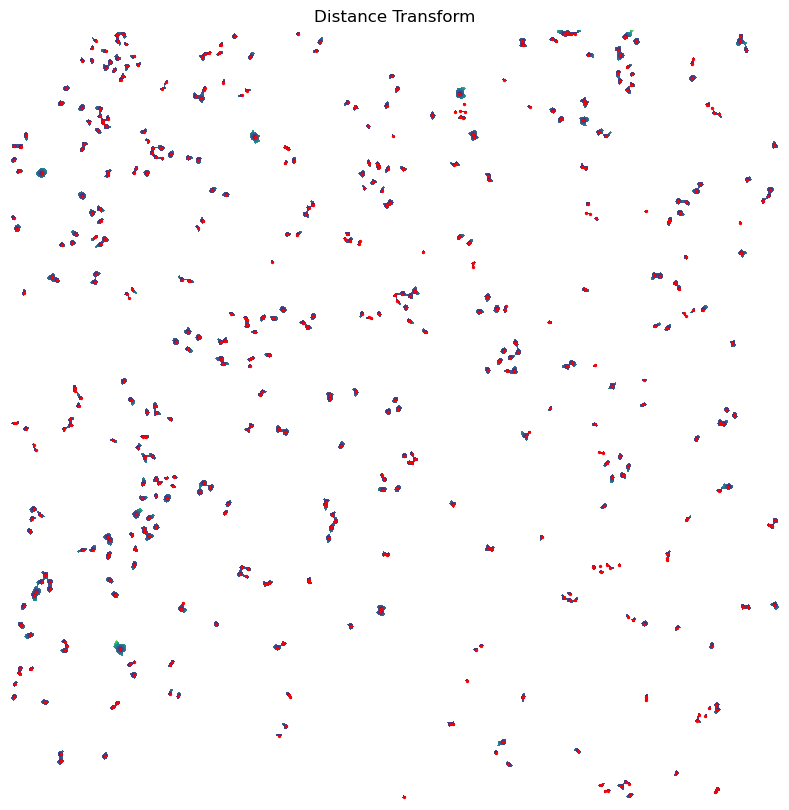

[30/07/2024 23:36:41] Performing filtering of nucleus with specified thresholds [200, 1000] from config file.
[30/07/2024 23:36:41] Removed 47 nuclei as they fell outside of the threshold range [200, 1000].
[30/07/2024 23:36:42] Segmentation debugging_seg_size_filter_results_nucleus written to sdata object.
[30/07/2024 23:36:42] Total time to perform nucleus size filtering: 1.3749570846557617 seconds
[30/07/2024 23:36:44] Filtered out 7 nuclei due to contact filtering.
[30/07/2024 23:36:44] Normalizing each channel to the same range
[30/07/2024 23:36:46] Cytosol Potential Mask generated.
[30/07/2024 23:36:48] Performing filtering of cytosol with specified thresholds [200, 6000] from config file.


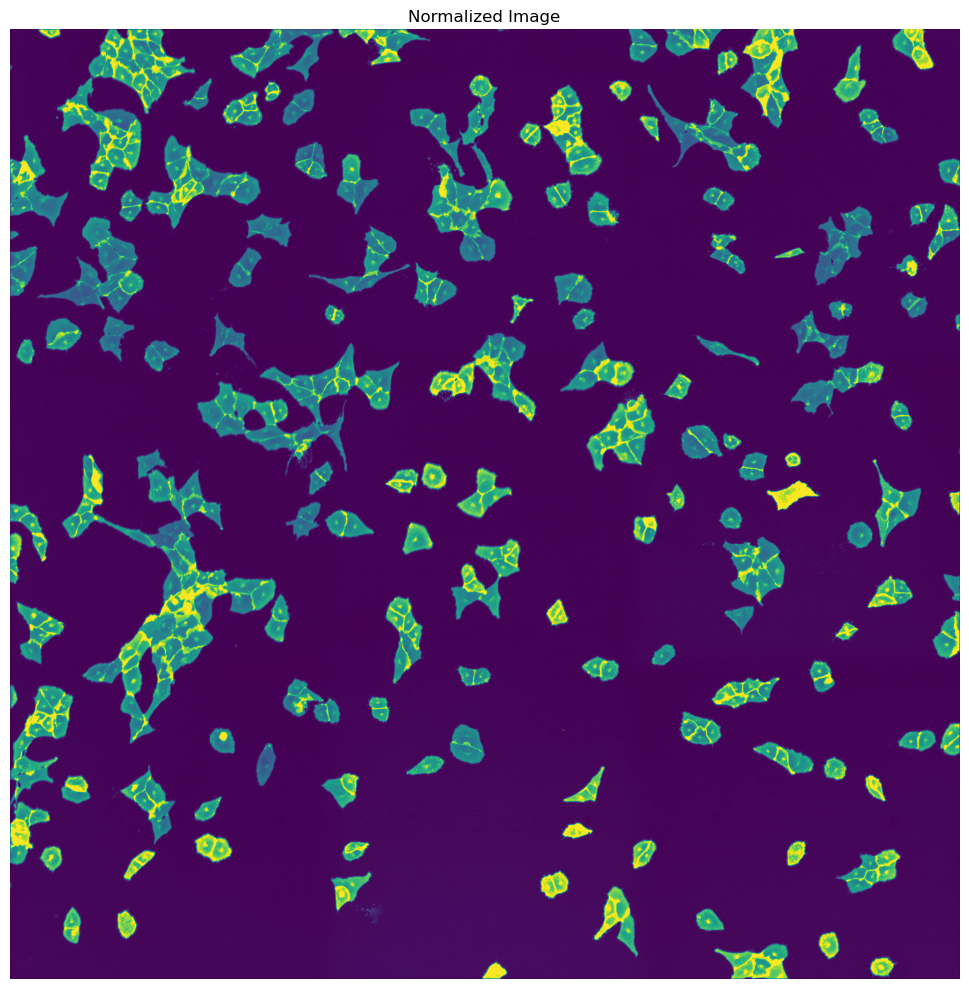

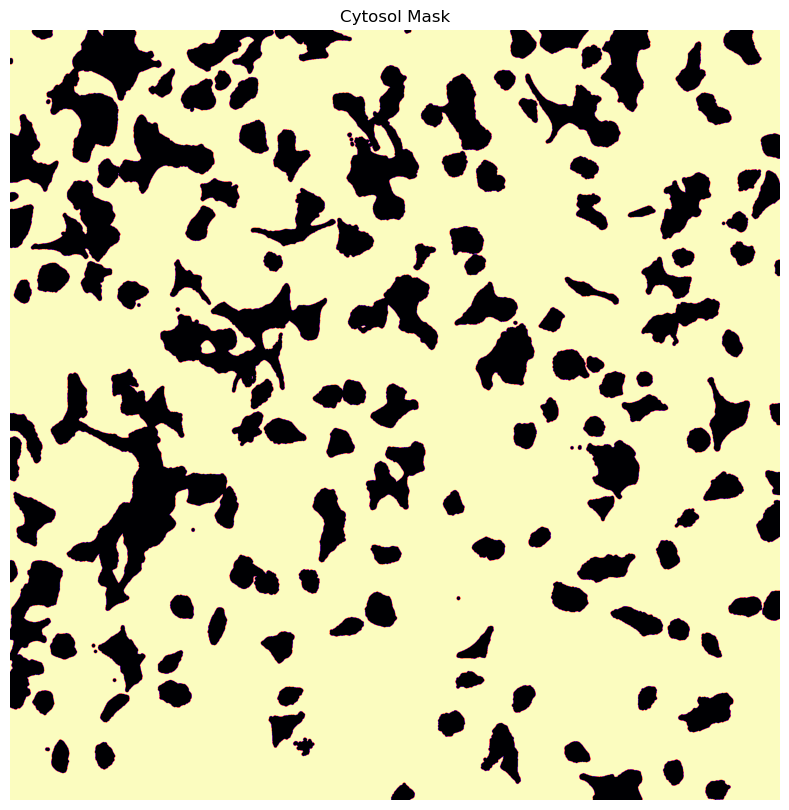

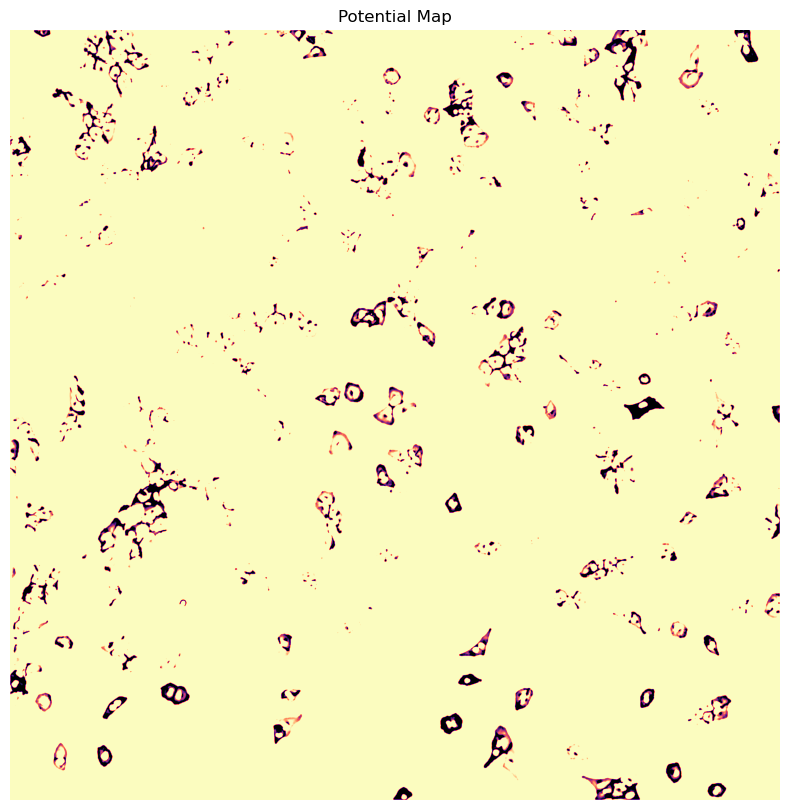

[30/07/2024 23:36:48] Removed 79 nuclei as they fell outside of the threshold range [200, 6000].
[30/07/2024 23:36:49] Segmentation debugging_seg_size_filter_results_cytosol written to sdata object.
[30/07/2024 23:36:49] Total time to perform cytosol size filtering: 1.8612589836120605 seconds
Channels shape:  (2, 3040, 3038)
[30/07/2024 23:36:52] Segmentation seg_all_nucleus written to sdata object.
[30/07/2024 23:36:53] Segmentation seg_all_cytosol written to sdata object.
[30/07/2024 23:36:53] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./WGASegmentation_q2k8e7yz'>


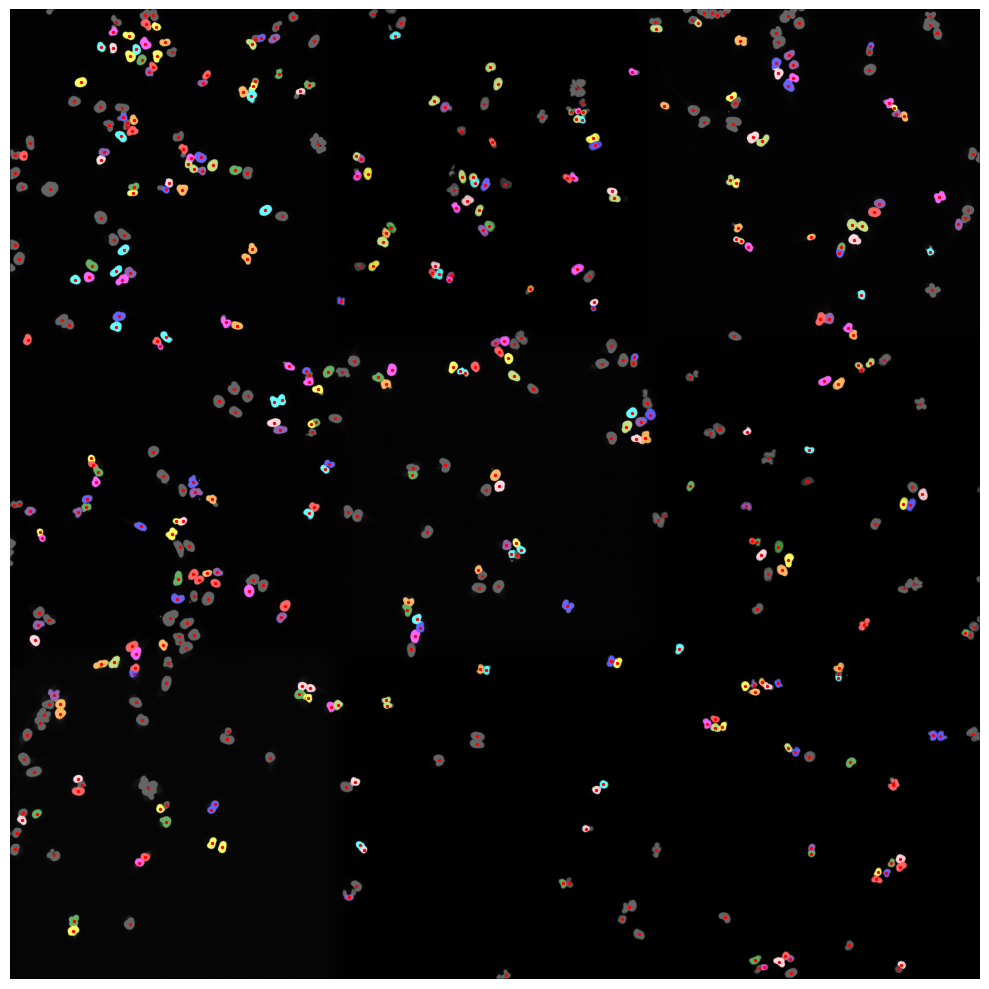

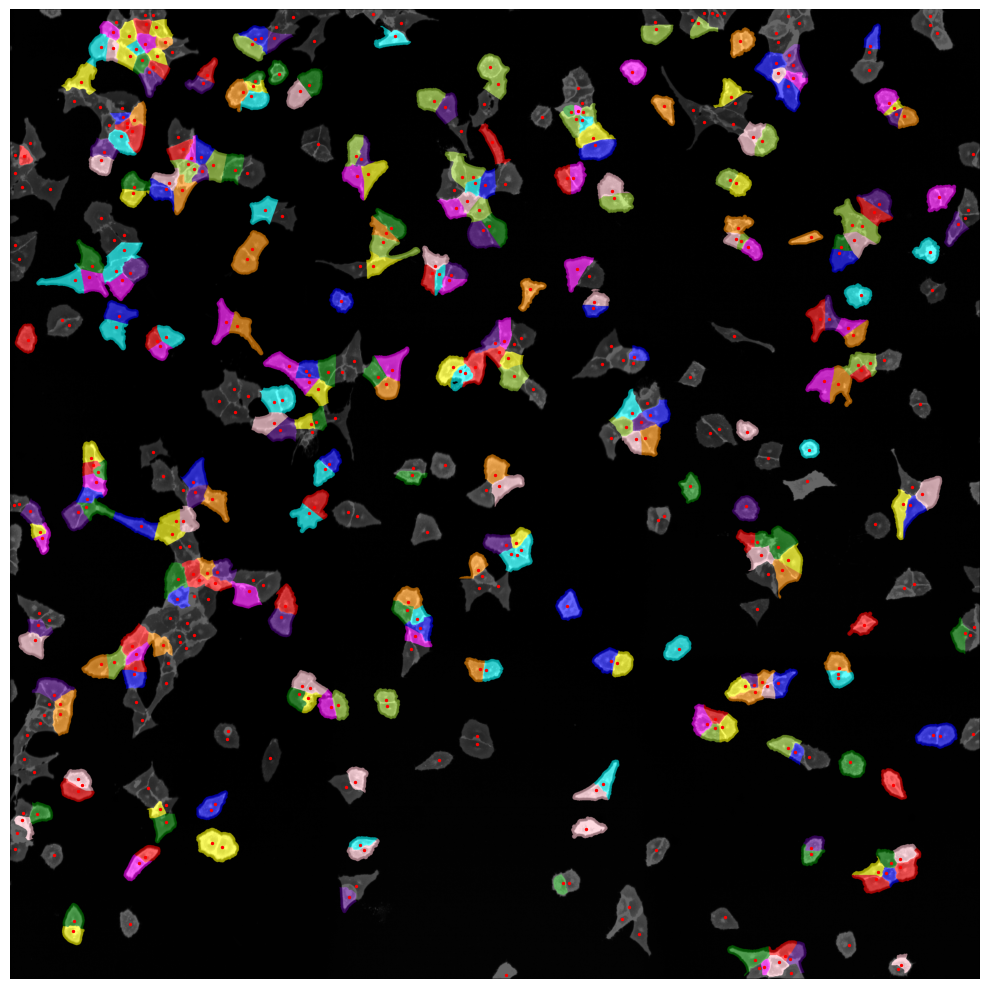

In [3]:
project.segment()

### Looking at Segmentation Results

The Segmentation Results are written to a hdf5 file called `segmentation.h5` located in the segmentation directory of our scPortrait project.

The file contains two datasets: `channels` and `labels`. Channels contains the input images and `labels` the generated segmentation masks.

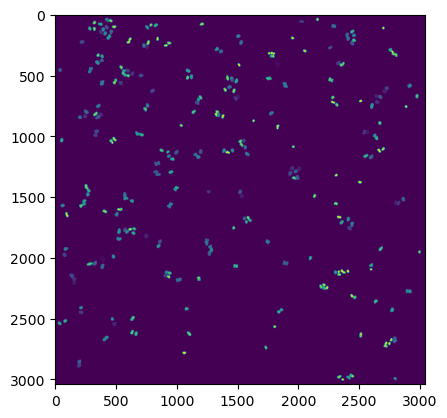

In [9]:
plt.imshow(project.sdata.labels["seg_all_nucleus"])


If we look at the `labels` dataset we can see that it contains a numpy array containing two segmentation masks: the nuclear segmentation and the cytosol segmentation generated by our chosen segmentation method.

<HDF5 dataset "labels": shape (2, 3040, 3038), type "<u4">


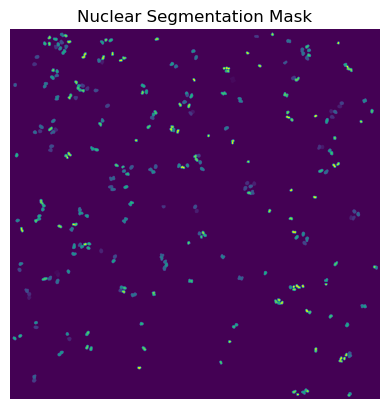

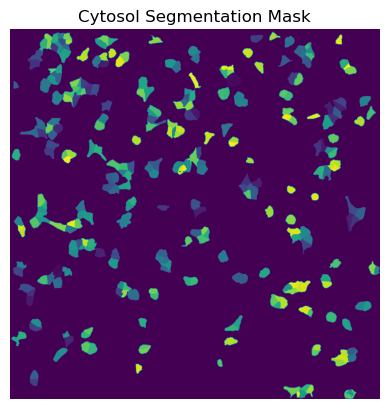

In [ ]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")
    print(segmentation)

    plt.figure()
    plt.imshow(segmentation[0])
    plt.axis("off")
    plt.title("Nuclear Segmentation Mask")

    plt.figure()
    plt.imshow(segmentation[1])
    plt.axis("off")
    plt.title("Cytosol Segmentation Mask")


Each segmentation mask is an array where each pixel is assigned either to background (`0`) or to a specific cell (`cellid: whole number`).

If we zoom in on the corner of the segmentation mask of a nucleus the numpy array would look like this:

[[396 396 396 396 396 396   0   0   0   0]
 [396 396 396 396 396 396 396 396   0   0]
 [396 396 396 396 396 396 396 396 396   0]
 [396 396 396 396 396 396 396 396 396   0]
 [396 396 396 396 396 396 396 396 396 396]
 [396 396 396 396 396 396 396 396 396 396]
 [396 396 396 396 396 396 396 396 396 396]
 [396 396 396 396 396 396 396 396 396 396]
 [396 396 396 396 396 396 396 396 396 396]
 [396 396 396 396 396 396 396 396 396 396]
 [396 396 396 396 396 396 396 396 396 396]
 [396 396 396 396 396 396 396 396 396   0]
 [396 396 396 396 396 396 396 396 396   0]
 [396 396 396 396 396 396 396 396   0   0]
 [396 396 396 396 396 396   0   0   0   0]
 [396 396 396 396   0   0   0   0   0   0]
 [396 396   0   0   0   0   0   0   0   0]
 [396   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


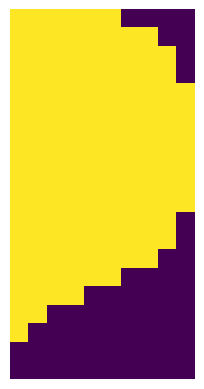

In [ ]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")

    plt.imshow(segmentation[0, 230:250, 945:955])
    plt.axis("off")
    print(segmentation[0, 230:250, 945:955])


## Extracting single-cell images

Once we have generated a segmentation mask, the next step is to extract single-cell images of segmented cells in the dataset.

Like during the segmentation there are several extraction methods to choose from. For regular scPortrait projects we need the `HDF5CellExtraction` method. This will extract single-cell images for all cells segmentated in the dataset and write them to a hdf5 file.

The parameters with which `HDF5CellExtraction` will run are again specified in the `config.yml` file.

                HDF5CellExtraction:
                    compression: True
                    threads: 80 # threads used in multithreading
                    image_size: 128 # image size in pixel
                    cache: "."
                    hdf5_rdcc_nbytes: 5242880000 # 5gb 1024 * 1024 * 5000 
                    hdf5_rdcc_w0: 1
                    hdf5_rdcc_nslots: 50000

[30/07/2024 23:41:11] Current Project Status:
[30/07/2024 23:41:11] --------------------------------
[30/07/2024 23:41:11] Input Image Status: True
[30/07/2024 23:41:11] Nucleus Segmentation Status: True
[30/07/2024 23:41:11] Cytosol Segmentation Status: True
[30/07/2024 23:41:11] Centers Status: True
[30/07/2024 23:41:11] --------------------------------
[30/07/2024 23:41:11] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_j4zguefi for HDF5CellExtraction
[30/07/2024 23:41:11] Created new directory for extraction results: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/extraction/data
[30/07/2024 23:41:11] Setup output folder at /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/extraction/data
[30/07/2024 23:41:11] Found 2 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_nucleus', 'seg_all_cytosol']

  0%|          | 0/3 [00:00<?, ?it/s]

[30/07/2024 23:41:12] Finished transferring data to memory mapped arrays. Time taken: 1.67 seconds.
[30/07/2024 23:41:12] Using batch size of 100 for multiprocessing.
[30/07/2024 23:41:12] Reducing number of threads to 4 to match number of cell batches to process.
[30/07/2024 23:41:12] Running in multiprocessing mode with 4 threads.


Processing cell batches:   0%|          | 0/4 [00:00<?, ?it/s]

multiprocessing done.
[30/07/2024 23:41:13] Finished extraction in 0.32 seconds (1003.49 cells / second)
[30/07/2024 23:41:13] Transferring results to final HDF5 data container.
[30/07/2024 23:41:13] number of cells too close to image edges to extract: 14
[30/07/2024 23:41:13] A total of 14 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/segmentation/removed_classes.csv.
[30/07/2024 23:41:13] Transferring extracted single cells to .hdf5
[30/07/2024 23:41:13] single-cell index created.


/Users/sophia/Documents/GitHub/SPARCSspatial/src/scportrait/pipeline/extraction.py:676: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[30/07/2024 23:41:13] single-cell data created
[30/07/2024 23:41:13] single-cell index labelled created.
[30/07/2024 23:41:13] channel information created.
[30/07/2024 23:41:13] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_j4zguefi'>


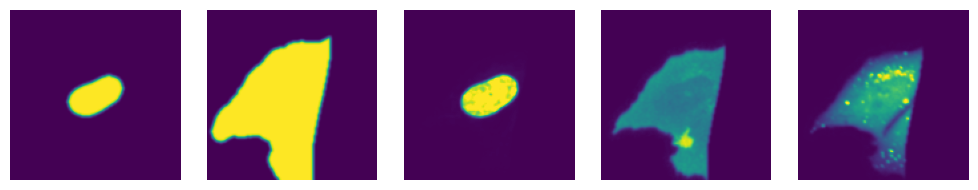

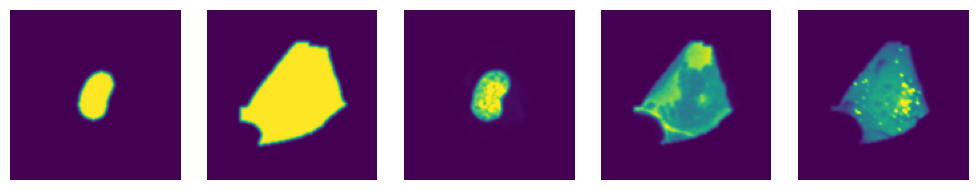

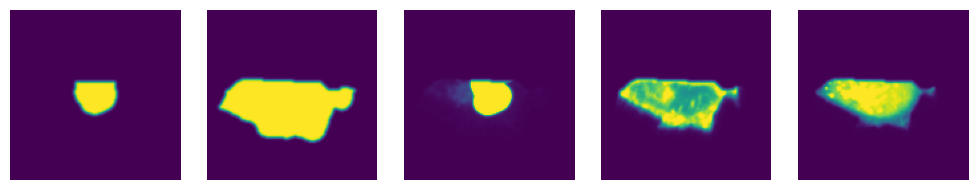

In [3]:
project.extract()

### Look at extracted single-cell images

The extracted single-cell images are written to a h5py file `single_cells.h5` located under `extraction\data` within the project folder.

The file contains two datasets: `single_cell_data` and `single_cell_index`. `single_cell_data` contains the extracted single cell images while `single_cell_index` contains the cell id of the extracted cell at that location.

In [4]:
import h5py

with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    print(hf.keys())


<KeysViewHDF5 ['channel_information', 'single_cell_data', 'single_cell_index', 'single_cell_index_labelled']>


So if we want to look at the nth cell in the dataset we can first check which cellid was assigned to this cell by looking at the nth entry in the `single_cell_index` dataset and then get the extracted single-cell images from the `single_cell_data` dataset.

The extracted single-cell images represent the following information in this order:  
<ol>
1. nucleus mask<br>
                2. cytosol mask  <br>
                3. nucleus channel <br> 
                4. cytosol channel <br> 
                5. other channels<br>
</ol> 

Here we will demonstrate with the 10th cell in the dataset.

cell id:  [10 43]


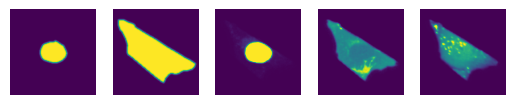

In [5]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print("cell id: ", index[10])

    image = images[10]

    fig, axs = plt.subplots(1, 5)

    for i, _img in enumerate(image):
        axs[i].imshow(_img)
        axs[i].axis("off")

## Classification of extracted single-cells

Next we can apply a pretained model to classify our cells within the scPortrait project. 

Within the `config.yml` we specify which model should be used for inference and we can give it a name. 

                MLClusterClassifier:
                    channel_classification: 4
                    threads: 24 #
                    batch_size: 900
                    dataloader_worker: 0 #needs to be 0 if using cpu
                    standard_scale: False
                    exp_transform: False
                    log_transform: False
                    network: "autophagy_classifier2.1"
                    classifier_architecture: "VGG2_old"
                    screen_label: "Autophagy_15h_classifier2.1"
                    epoch: "max"
                    encoders: ["forward"]
                    inference_device: "cpu"

Here e.g. we are using a pretrained model included within the scPortrait library `autophagy_classifier2.1` and are naming the results from this model `Autophagy_15h_classifier2.1`. 

Model overview:

<img src="../images/classifying_autophagy.png" alt="autophagy classification with example cells" width="800"/>


The inference results will be written to a new folder generated under `classification` with this name. 

If we want to use a model we trained ourselves that is not yet included within the scPortrait library we can simply replace the network name in the config with the path to the checkpoint file generated by pytorch.


In [3]:
project.classify()

Lightning automatically upgraded your loaded checkpoint from v1.5.5 to v2.2.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../src/pretrained_models/autophagy/autophagy2.1/VGG2_autophagy_classifier2.1.cpkt`


[30/07/2024 23:30:39] Current Project Status:
[30/07/2024 23:30:39] --------------------------------
[30/07/2024 23:30:39] Input Image Status: True
[30/07/2024 23:30:39] Nucleus Segmentation Status: True
[30/07/2024 23:30:39] Cytosol Segmentation Status: True
[30/07/2024 23:30:39] Centers Status: True
[30/07/2024 23:30:39] --------------------------------
Using extraction directory: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/extraction/data/single_cells.h5
[30/07/2024 23:30:39] Initialized temporary directory at /Users/sophia/Documents/GitHub/SPARCSspatial/docs_source/pages/notebooks/MLClusterClassifier_nw1c65u5 for MLClusterClassifier
[30/07/2024 23:30:39] Started MLClusterClassifier classification.
[30/07/2024 23:30:39] Created new directory for classification results: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/classification/complete_Autophagy_15h_classifier2_1
[30/07/2024 23:30:39] CPU specified in config file but MP

/Users/sophia/mambaforge/envs/SPARCSspatial-dev/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403226260/work/aten/src/ATen/ParallelNative.cpp:228.)
  torch.set_num_threads(1)
/Users/sophia/mambaforge/envs/SPARCSspatial-dev/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403226260/work/aten/src/ATen/ParallelNative.cpp:228.)
  torch.set_num_threads(1)
/Users/sophia/mambaforge/envs/SPARCSspatial-dev/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of 

[30/07/2024 23:30:42] finished processing.
[30/07/2024 23:30:42] Results saved to file: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/classification/complete_Autophagy_15h_classifier2_1/inference_forward.csv
[30/07/2024 23:30:42] Table MLClusterClassifier_Autophagy_15h_classifier2_1_forward_nucleus written to sdata object.
[30/07/2024 23:30:42] Table MLClusterClassifier_Autophagy_15h_classifier2_1_forward_cytosol written to sdata object.
[30/07/2024 23:30:42] Results saved to file: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_1/project/classification/complete_Autophagy_15h_classifier2_1/inference_forward.csv
[30/07/2024 23:30:42] GPU memory before performing cleanup: None
[30/07/2024 23:30:42] GPU memory after performing cleanup: None
[30/07/2024 23:30:42] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/SPARCSspatial/docs_source/pages/notebooks/MLClusterClassifier_nw1c65u5'>


### looking at the generated results

The results are written to a csv file which we can load with pandas.

scPortrait writes the softmax results directly to csv as `ln()` for better precision. To transform these numbers back to the range between 0 and 1 we first need to apply the `np.exp` function.

In [6]:
results = pd.read_csv(f"{project_location}/classification/complete_Autophagy_15h_classifier2_1/inference_forward.csv", index_col = None)
results.result_0 = np.exp(results.result_0)
results.result_1 = np.exp(results.result_1)

results

result_0  result_1  label  cell_id
0    0.017376  0.982624      0       12
1    0.000513  0.999487      0       13
2    0.824287  0.175713      0       14
3    0.146088  0.853912      0       18
4    0.894452  0.105548      0       32
..        ...       ...    ...      ...
305  0.997982  0.002018      0      489
306  0.000234  0.999766      0      490
307  0.000014  0.999986      0      492
308  0.997871  0.002129      0      493
309  0.433668  0.566332      0      494

[310 rows x 4 columns]

Depending on the model we used what `result_0` and `result_1` represent will vary. Here we used a binary classification model were class 1 was cells deficient in autophagy. So `result_1` indicates the probability score that a cell has the label "autophagy off". `results_0` is simply `1 - result_1`


If we look at the distribution in our dataset we can see that almost all cells are classified as "autophagy defective". Since the input images were from unstimulated wt cells this matches to our expectation.

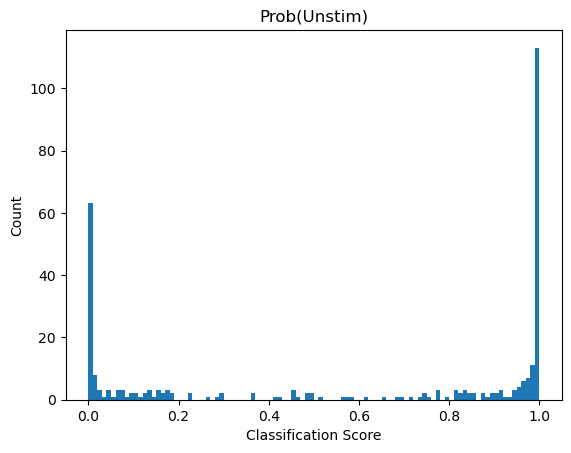

In [7]:
plt.hist(results.result_1, bins = 100);
plt.title("Prob(Unstim)");
plt.xlabel("Classification Score");
plt.ylabel("Count");

## Exporting Cutting contours for excision on the LMD7

scPortrait directly interfaces with our other open-source python library [py-lmd](https://github.com/MannLabs/py-lmd) to easily select and export cells for excision on a Leica LMD microscope. 

Of note: this will require that the cells have been plates on a LMD compatible surface (like a PPS slide). scPortrait can of course also simply be used for data analysis procedures, then ignore this last step.

First we will select the cells we wish to excise based on their classification score. Here we have chosen a threadhold >= 0.99999 for bin1 and a threshold <= 0.9 for bin2. 

In [8]:
cell_ids_bin1 = results[results.result_1 >= 0.99999].cell_id.tolist()
cell_ids_bin2 = results[results.result_1 <= 0.9].cell_id.tolist()

print("number of cells to excise:",len(cell_ids_bin1) + len(cell_ids_bin2))

number of cells to excise: 174


The cells can then be allocated into different wells.

In [9]:
cells_to_select = [{"name": "bin1", "classes": list(cell_ids_bin1), "well":"A1"},
                   {"name": "bin2", "classes": list(cell_ids_bin2), "well":"B1"},
                   ]

In addition to defining which cells we want to excise, we also need to pass the location of the calibration crosses so that we can transfer the image coordinate system into a cutting coordinate system. You can read up on this [here](https://mannlabs.github.io/py-lmd/html/pages/segmentation_loader.html#different-coordinate-systems).

To obtain the coordinates of your reference points simply open your stitched image in e.g. FIJI and navigate to the location of your reference points. Then write out the coordinates for each point.

In [10]:
marker_0 = (0, 0)
marker_1 = (2000, 0)
marker_2 = (0, 2000)

calibration_marker = np.array([marker_0, marker_1, marker_2])

As with the previous methods, additional parameters can be passed to the selection function via the `config.yml` file which adapts the behaviour of how cutting shapes are generated. You can read up more on this [here](https://mannlabs.github.io/py-lmd/html/pages/segmentation_loader.html#overview-of-configuration).

                LMDSelection:
                    processes: 20

                    # defines the channel used for generating cutting masks
                    # segmentation.hdf5 => labels => segmentation_channel
                    # When using WGA segmentation:
                    #    0 corresponds to nuclear masks
                    #    1 corresponds to cytosolic masks.
                    segmentation_channel: 0

                    # dilation of the cutting mask in pixel
                    shape_dilation: 16

                    # number of datapoints which are averaged for smoothing
                    # the number of datapoints over an distance of n pixel is 2*n
                    smoothing_filter_size: 25

                    # fold reduction of datapoints for compression
                    poly_compression_factor: 30
                    
                    # can be "none", "greedy", or "hilbert"
                    path_optimization: "hilbert"
                    
                    # number of nearest neighbours for optimized greedy search
                    greedy_k: 15
                    
                    # hilbert curve order
                    hilbert_p: 7



In [12]:
project.select(cells_to_select, calibration_marker)

TypeError: unhashable type: 'list'